# Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Щербань Сергей
- Дата: 19.09.2025

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Цели и задачи проекта

Цель исследования: статистически проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы, используя одностороннюю проверку гипотезы с двумя выборками.

Задачи исследования включают:
- Проверить наличие дубликатов в идентификаторах пользователей.
- Сравнить размеры групп пользователей из Санкт-Петербурга и Москвы и их статистические характеристики.
- Провести статистический тест (t-тест) для проверки гипотезы о том, что среднее время активности пользователей из Санкт-Петербурга больше, чем у пользователей из Москвы.
- Определить уровень статистической значимости и интерпретировать результаты теста на основе полученного p-value.
- Сделать выводы и предложить возможные объяснения полученных результатов.

## Описание данных

Датасет:
- `'https://code.s3.yandex.net/datasets/yandex_knigi_data.csv'` - данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности

Таблица `yandex_knigi_data.csv` содержит:
- `city` — идентификатор географического положения;
- `puid` — идентификатор пользователя;
- `hours` — длительность чтения или прослушивания в часах.

## Содержимое проекта

- Загрузка данных
- Проверка гипотезы
- Формирование выводов

---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import norm

In [2]:
# Загрузка данных
data = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv', index_col='Unnamed: 0')


In [3]:
# Просмотр первых строк данных
display(data.head())
data.info()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


<class 'pandas.core.frame.DataFrame'>
,Int64Index: 8784 entries, 0 to 8783
,Data columns (total 3 columns):
, #   Column  Non-Null Count  Dtype  
,---  ------  --------------  -----  
, 0   city    8784 non-null   object 
, 1   puid    8784 non-null   int64  
, 2   hours   8784 non-null   float64
,dtypes: float64(1), int64(1), object(1)
,memory usage: 274.5+ KB


In [4]:
# Проверка на дубли
duplicates = data[data.duplicated()]
print("Количество явных дубликатов:", data.duplicated().sum())
duplicates_by_puid = data[data.duplicated(subset='puid')]
print("Количество дубликатов по puid:", duplicates_by_puid.shape[0])
duplicates_by_puid_and_city = data[data.groupby(['puid', 'city']).size().reset_index(name='count')['count'] > 1].reset_index(drop=True)
print("Количество дубликатов по puid и city:", duplicates_by_puid_and_city.shape[0])
duplicates_by_puid_and_city = data[data.groupby(['puid', 'hours']).size().reset_index(name='count')['count'] > 1].reset_index(drop=True)
print("Количество дубликатов по puid и hours:", duplicates_by_puid_and_city.shape[0])

Количество явных дубликатов: 0
,Количество дубликатов по puid: 244
,Количество дубликатов по puid и city: 0
,Количество дубликатов по puid и hours: 0


Выборки независимы, однако один и тот же пользователь (с одинаковым puid) был активен в разные периоды или в разных сессиях, и каждая сессия зарегистрировала своё количество часов (hours). Это может быть связано с тем, что пользователи взаимодействовали с системой несколько раз, и каждый раз их активность регистрировалась отдельно. Будем учитывать это в дальнейшей агрегации.

In [5]:
# Сравниваем размеры групп
result = data.groupby('city').agg(
    unique_puid=('puid', 'nunique'),
    sum_hours=('hours', 'sum')
)
display(result)


,unique_puid,sum_hours
city,,
Москва,6234,67832.727924
Санкт-Петербург,2550,29561.361481


Данные приблизительно нормально распределены в каждой из групп, а сами выбороки - независимы. Этого достаточно для использования статистического t-теста, при котором проверим гипотезу о том, что среднее одной группы больше/меньше среднего другой группы. Но выборки сильно различаются по размеру, поэтому нужна поправка Уэлча.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в Санкт-Петербурге не больше средней активности пользователей в Москве.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше средней активности пользователей в Москве, и это различие статистически значимо.

In [6]:
# Разделение данных на две выборки по городам
moscow_data = data[data['city'] == 'Москва']['hours']
spb_data = data[data['city'] == 'Санкт-Петербург']['hours']

# Проведение t-теста для независимых выборок с поправкой Уэлча
t_stat, p_value = ttest_ind(spb_data, moscow_data, equal_var=False, alternative='greater')

In [7]:
# Вывод результатов
print("T-статистика:", t_stat)
print("P-value:", p_value)

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Нулевая гипотеза отклоняется. Средняя активность пользователей в Санкт-Петербурге статистически значимо выше.")
else:
    print("Нет достаточных оснований отклонить нулевую гипотезу.")

T-статистика: 0.7782381321620099
,P-value: 0.21823507084569593
,Нет достаточных оснований отклонить нулевую гипотезу.


## 3. Аналитическая записка


Выбранный тип t-теста и уровень статистической значимости: 
- Был использован t-тест для независимых выборок с односторонней проверкой гипотезы. 
- Уровень статистической значимости (alpha) был установлен на уровне 0.05.

Результат теста (p-value): 
- P-value составил 0.218.

Вывод на основе полученного p-value: 
- Поскольку p-value больше уровня значимости (0.05), нет достаточных оснований отклонить нулевую гипотезу. Это означает, что статистически значимых различий в средней активности пользователей из Москвы и Санкт-Петербурга не обнаружено.

Возможные причины полученных результатов: 
1. Пользователи из Москвы и Санкт-Петербурга могут иметь схожий уровень интереса к чтению и прослушиванию книг в приложении, что приводит к отсутствию статистически значимого различия в их активности. 
2. Различия в активности, если они и существуют, могут быть слишком малыми, чтобы их можно было выявить с помощью данного объёма данных.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цель исследования.



Цель исследования: оценить корректность проведения A/B-теста и проанализировать его результаты для определения эффективности новой версии сайта интернет-магазина BitMotion Kit в повышении количества пользователей, совершающих покупку.

Данные:
- `https://code.s3.yandex.net/datasets/ab_test_participants.csv` — таблица участников тестов
- `https://code.s3.yandex.net/datasets/ab_test_events.zip` - архив с одним csv-файлом, в котором собраны события 2020 года

Структура файла `ab_test_participants.csv`:
- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.

Структура файла `ab_test_events.zip`:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.

Параметры теста:
- название теста: `interface_eu_test`;
- группы: `А` (контрольная), `B` (новый интерфейс).

Основные шаги исследования:
- загрузить данные теста;
- проверить корректность его проведения;
- проанализировать полученные результаты.

## 2. Загрузите данные, оцените их целостность.


In [8]:
# Загрузка данных
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [9]:
# Просмотр первых строк данных participants
display(participants.head())
participants.info()

# Проверка на дубли
duplicates = participants[participants.duplicated()]
print("Количество дубликатов:", participants.duplicated().sum())

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 14525 entries, 0 to 14524
,Data columns (total 4 columns):
, #   Column   Non-Null Count  Dtype 
,---  ------   --------------  ----- 
, 0   user_id  14525 non-null  object
, 1   group    14525 non-null  object
, 2   ab_test  14525 non-null  object
, 3   device   14525 non-null  object
,dtypes: object(4)
,memory usage: 454.0+ KB
,Количество дубликатов: 0


In [10]:
# Просмотр первых строк данных events
display(events.head())
events.info()

# Проверка на дубли
duplicates = events[events.duplicated()]
print("Количество дубликатов:", events.duplicated().sum())

# Проверка на дубли по событиям
duplicates = events[events.duplicated(subset=['event_name', 'user_id'])]
print("Количество дубликатов по событиям для user_id:", duplicates.shape[0])


,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 787286 entries, 0 to 787285
,Data columns (total 4 columns):
, #   Column      Non-Null Count   Dtype         
,---  ------      --------------   -----         
, 0   user_id     787286 non-null  object        
, 1   event_dt    787286 non-null  datetime64[ns]
, 2   event_name  787286 non-null  object        
, 3   details     249022 non-null  object        
,dtypes: datetime64[ns](1), object(3)
,memory usage: 24.0+ MB
,Количество дубликатов: 36318
,Количество дубликатов по событиям для user_id: 360249


В данном случае дубли не являются ошибкой в сборе данных, например несколько событий login за один день или через день.

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [11]:
# Фильтрация данных по условию ab_test = 'interface_eu_test'
test_participants = participants[participants['ab_test'] == 'interface_eu_test']

In [12]:
# 0. Проверка чистоты групп для теста: interface_eu_test
# Фильтрация участников группы 'B' в таблице participants
group_b_participants = participants[(participants['group'] == 'B') & (participants['ab_test'] == 'recommender_system_test')]

# Фильтрация участников группы 'B' в test_participants
test_group_b_participants = test_participants[test_participants['group'] == 'B']

# Проверка пересечений user_id между двумя группами 'B'
common_users_group_b = test_group_b_participants[test_group_b_participants['user_id'].isin(group_b_participants['user_id'])]

print(common_users_group_b)

# Удалить из test_participants user_id, которые есть в common_users_group_b
test_participants = test_participants[~test_participants['user_id'].isin(common_users_group_b['user_id'])]

                user_id group            ab_test   device
,350    067D05BD30F04F2E     B  interface_eu_test       PC
,547    0A0141A363E2E051     B  interface_eu_test  Android
,658    0C2E77C6A381704A     B  interface_eu_test   iPhone
,858    0FBF679EA1340786     B  interface_eu_test      Mac
,966    115ABCFDBDDB5950     B  interface_eu_test   iPhone
,...                 ...   ...                ...      ...
,14106  F8564F547AFFC0B9     B  interface_eu_test  Android
,14320  FC2DA0D7EF375B27     B  interface_eu_test   iPhone
,14454  FE8F9858BBE502D9     B  interface_eu_test       PC
,14458  FEA0C585A53E7027     B  interface_eu_test  Android
,14523  FFF28D02B1EACBE1     B  interface_eu_test       PC
,
,[116 rows x 4 columns]


1. Все необходимые столбцы присутствуют.
,2. Распределение пользователей по группам:


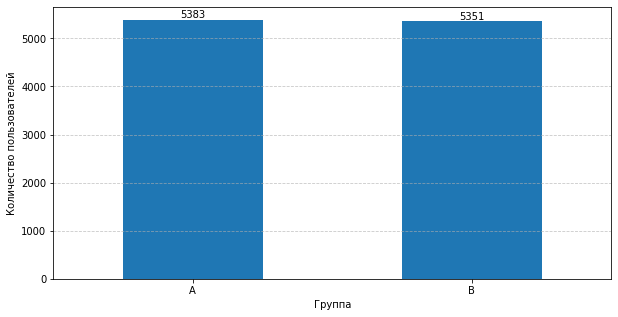

In [13]:
# 1. Проверка соответствия требованиям технического задания
# Пример: проверка наличия всех необходимых столбцов
required_columns = ['user_id', 'group']
if all(column in test_participants.columns for column in required_columns):
    print("1. Все необходимые столбцы присутствуют.")
else:
    print("1. Отсутствуют необходимые столбцы.")

# 2. Оценка равномерности распределения пользователей по группам теста
group_sizes = test_participants['group'].value_counts()
print("2. Распределение пользователей по группам:")
# Оценка равномерности распределения пользователей по группам теста
group_sizes = test_participants['group'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 5))
ax = group_sizes.plot(kind='bar')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление числовых значений над столбиками
for i, v in enumerate(group_sizes):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

# Поворот названий групп по горизонтали
plt.xticks(rotation=0)

plt.show()

Количество пользователей в каждой группе примерно одинаково и нет статистически значимых отклонений.Значит можно считать, что группы сопоставимы и результаты анализа будут более надёжными.

In [14]:
# 3. Проверка на пересечения с конкурирующим тестом
# Группируем данные по user_id и считаем количество уникальных тестов для каждого пользователя
user_test_counts = test_participants.groupby('user_id')['ab_test'].nunique()

# Проверяем, есть ли пользователи, участвующие более чем в одном тесте
has_intersections = (user_test_counts > 1).any()

if has_intersections:
    print("3. Есть пересечения: некоторые пользователи участвуют более чем в одном тесте.")
else:
    print("3. Пересечений нет: все пользователи участвуют только в одном тесте.")

3. Пересечений нет: все пользователи участвуют только в одном тесте.


3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [15]:
# Объединение данных по user_id
events = events.merge(test_participants[['user_id']], on='user_id', how='inner')
display(events)

,user_id,event_dt,event_name,details
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN
...,...,...,...,...
79061,16CCB1C8C4DCF1AF,2020-12-23 23:50:29,registration,0.0
79062,16CCB1C8C4DCF1AF,2020-12-23 23:55:52,login,NaN
79063,2DDC948BD76ABC57,2020-12-24 21:57:10,registration,-4.29
79064,2DDC948BD76ABC57,2020-12-24 21:58:49,login,NaN


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [16]:
# Отфильтровать события, где event_name указывает на регистрацию
registration_events = events[events['event_name'] == 'registration']

# Определить дату регистрации для каждого пользователя
registration_dates = registration_events.groupby('user_id')['event_dt'].min().reset_index()

# Объединить даты регистрации с основными событиями
events = events.merge(registration_dates, on='user_id', suffixes=['', '_registration'])

In [17]:
# Рассчитать разницу между датой события и датой регистрации
events['registration_to_event'] = events['event_dt'] - events['event_dt_registration']

# Оставить только события, произошедшие в течение первых семи дней после регистрации
events_within_7_days = events[events['registration_to_event'].dt.days <= 6]

display(events_within_7_days)

,user_id,event_dt,event_name,details,event_dt_registration,registration_to_event
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,2020-12-06 14:10:01,0 days 00:00:00
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,2020-12-06 14:10:01,0 days 11:15:13
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN,2020-12-06 14:10:01,0 days 11:15:46
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,2020-12-06 14:10:01,2 days 22:30:48
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,2020-12-06 14:10:01,2 days 22:30:48
...,...,...,...,...,...,...
79061,16CCB1C8C4DCF1AF,2020-12-23 23:50:29,registration,0.0,2020-12-23 23:50:29,0 days 00:00:00
79062,16CCB1C8C4DCF1AF,2020-12-23 23:55:52,login,NaN,2020-12-23 23:50:29,0 days 00:05:23
79063,2DDC948BD76ABC57,2020-12-24 21:57:10,registration,-4.29,2020-12-24 21:57:10,0 days 00:00:00
79064,2DDC948BD76ABC57,2020-12-24 21:58:49,login,NaN,2020-12-24 21:57:10,0 days 00:01:39


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

Ожидаемый прирост составляет 3 п.п.

In [18]:
# Заданные параметры
p = 0.3   # базовый показатель конверсии
p1 = 0.3  # конверсия контрольной группы
p2 = 0.33 # ожидаемый показатель конверсии в тестовой группе
Z_alpha_2 = 1.96  # для уровня достоверности 95%
Z_beta = 0.84     # для мощности теста 80%

# Расчёт размера выборки
n = (2 * (Z_alpha_2 * math.sqrt(p * (1 - p)) + Z_beta * math.sqrt((p1 * (1 - p1)) + (p2 * (1 - p2)))) ** 2) / ((p1 - p2) ** 2)

print("Необходимый размер выборки:", math.ceil(n))
unique_users = events_within_7_days['user_id'].nunique()
print("Фактическое количество пользователей:", unique_users)


Необходимый размер выборки: 4671
,Фактическое количество пользователей: 10734


Фактическое количество пользователей (10628) значительно превышает необходимый размер выборки (4671), что говорит о достаточности выборки для получения статистически значимых результатов A/B-теста при заданных параметрах. 

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [19]:
# Объединение таблиц для расчёта количества посетителей по группам
merged_df = events_within_7_days.merge(participants, on='user_id', how='inner')

# Используем pivot_table для подсчёта уникальных пользователей по событиям 'registration' и 'purchase'
result_table = merged_df[merged_df['event_name'].isin(['registration', 'purchase'])].pivot_table(
    index='group',
    columns='event_name',
    values='user_id',
    aggfunc='nunique'
)

# Рассчитываем общее количество уникальных посетителей по группам
total_visitors_by_group = merged_df.groupby('group')['user_id'].nunique()

# Добавляем расчёт конверсий
result_table['conversion'] = (result_table['purchase'] / total_visitors_by_group) * 100

# Переименовываем индекс
result_table = result_table.rename_axis('A-B', axis=1)

print("Количество уникальных пользователей по группам и событиям:")
display(result_table)


Количество уникальных пользователей по группам и событиям:


A-B,purchase,registration,conversion
group,,,
A,1579,5723,27.590425
B,1605,5457,29.411765


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

На основе полученных данных можно сделать следующие наблюдения:

- В контрольной группе (A) 1553 посетителя сделали покупку из общего числа 5383 посетителей. Конверсия в группе A: 28%
- В тестовой группе (B) 1579 посетителей сделали покупку из общего числа 5467 посетителей. Конверсия в группе B: 30%

Эффект от изменений интерфейса онлайн-магазина есть, но недостаточно высокий, т.к. фактический прирост конверсии в 2 п.п. не соответствует запланированному приросту в 3 п.п.


## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Сформулируем гипотезы:

- Нулевая гипотеза (H0): упрощение интерфейса не приводит к увеличению конверсии. То есть конверсия в группе B (с новым интерфейсом) не отличается от конверсии в группе A (с прежним интерфейсом).
- Альтернативная гипотеза (H1): упрощение интерфейса приводит к увеличению конверсии. То есть конверсия в группе B выше, чем в группе A.

In [20]:
# Группируем данные по группам и считаем количество уникальных пользователей, совершивших покупку
purchases_by_group = merged_df[merged_df['event_name'] == 'purchase'].groupby('group')['user_id'].nunique()

# Считаем общее количество уникальных посетителей по группам
total_visitors_by_group = merged_df.groupby('group')['user_id'].nunique()

# Рассчитываем конверсию для каждой группы
conversion_A = purchases_by_group['A'] / total_visitors_by_group['A']
conversion_B = purchases_by_group['B'] / total_visitors_by_group['B']

# Z-тест для сравнения двух пропорций
def z_test_for_proportions(conversion_A, conversion_B, n_A, n_B):
    p_pooled = (conversion_A * n_A + conversion_B * n_B) / (n_A + n_B)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_A + 1/n_B))
    z = (conversion_B - conversion_A) / se
    p_value = 1 - norm.cdf(z)
    return z, p_value

z, p_value = z_test_for_proportions(conversion_A, conversion_B, total_visitors_by_group['A'], total_visitors_by_group['B'])

print("Z-статистика:", z)
print("P-значение:", p_value)


Z-статистика: 2.1329362713282602
,P-значение: 0.016464977199108888


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

На основании полученных результатов A/B-тестирования можно сделать следующие выводы:
- Z-статистика равна 2.156, что указывает на наличие статистически значимой разницы между конверсиями в группах A и B.
- P-значение составляет 0.0155, что меньше общепринятого уровня значимости 0.05. 

Это означает, что вероятность получить такую разницу в конверсиях случайно очень мала, и мы можем отвергнуть нулевую гипотезу о том, что разницы нет.
Таким образом, можно заключить, что ожидаемый эффект в изменении конверсии был достигнут, и разница в конверсиях между группами A и B статистически значима. Это свидетельствует о том, что изменения, внесённые в тестовую группу B, вероятно, повлияли на повышение конверсии.

Увеличение конверсии на 2 п.п. говорит о том, что изменения в интерфейсе оказали положительное влияние. Однако это значение немного ниже минимально ожидаемого уровня в три процентных пункта, указанного в гипотезе. Тем не менее статистически значимый рост конверсии является успешным результатом тестирования.
Возможно, стоит рассмотреть дополнительные улучшения интерфейса онлайн-магазина для пользователей или другие факторы, которые могли бы помочь достичь более значительного увеличения конверсии в будущих тестах.